<a href="https://colab.research.google.com/github/malak-elbanna/SVM-Sklearn-and-from-scratch-models/blob/main/SVM_RBF_from_scratch_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from google.colab import files
from cvxopt import matrix, solvers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

import contextlib
import os
import sys

In [ ]:
class SVM_RBF:
  def __init__(self, C, gamma):
    self.C = C
    self.gamma = gamma

  def rbf_kernel(self, x1, x2):
    return np.exp(-self.gamma * np.linalg.norm(x1-x2)**2)

  def fit(self, X, y):
    n_samples, _ = X.shape

    #calc kernel matrix
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = self.rbf_kernel(X[i], X[j])

    # calc P, q, A, b, G, h for the quadprog solver
    P = matrix(np.outer(y,y)*K)
    q = matrix(np.ones(n_samples)*-1)
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)
    G = matrix(np.concatenate((np.eye(n_samples)*-1, np.eye(n_samples))))
    h = matrix(np.concatenate((np.zeros(n_samples), np.ones(n_samples))))

    # solve quadprog
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x']).flatten()

    # support vectors
    self.support_alphas = []
    self.indices = []
    self.support_vectors = []
    self.support_labels = []

    for i in range(len(alphas)):
      if (alphas[i] > 0):
          self.support_alphas.append(alphas[i])
          self.indices.append(i)
          self.support_vectors.append(X[i])
          self.support_labels.append(y[i])

    self.support_alphas = np.array(self.support_alphas)
    self.indices = np.array(self.indices)
    self.support_vectors = np.array(self.support_vectors)
    self.support_labels = np.array(self.support_labels)

    # bias
    self.b = 0
    if len(self.support_alphas) > 0:
        for n in range(len(self.support_alphas)):
            self.b += self.support_labels[n]
            self.b -= np.sum(self.support_alphas * self.support_labels * K[self.indices[n], self.indices])
        self.b /= len(self.support_alphas)
    else:
        self.b = 0

  def decision_function(self, X):
    decision_values = []
    for i in range(X.shape[0]):
        sum = 0
        for alpha, label, sv in zip(self.support_alphas, self.support_labels, self.support_vectors):
            kernelize = self.rbf_kernel(sv, X[i])
            sum += alpha * label * kernelize
        final_val = sum + self.b
        decision_values.append(final_val)
    decision_values = np.array(decision_values)
    return decision_values

  def predict(self, X):
    decision_values = self.decision_function(X)
    return np.sign(decision_values)

In [ ]:
# suppress the output
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
def plot(X, y, classifiers):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

  x1, x2 = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(x_min, x_max, 0.1))

  grid_points = np.c_[x1.ravel(), x2.ravel()]
  grid_predictions = np.zeros(len(grid_points))

  for i, model in enumerate(classifiers):
        prediction = model.predict(grid_points)
        grid_predictions = np.where(prediction == 1, i, grid_predictions)

  plt.figure(figsize=(10,8))
  plt.scatter(grid_points[:, 0], grid_points[:, 1], c=grid_predictions, cmap='viridis', s=6, alpha=0.5, marker='<')

  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o')

  plt.show()

In [ ]:
def applySVM(dataset):
    data = pd.read_csv(f'{dataset}.txt', sep="\t", skiprows=7, header=None, names=['X1','X2','y'])
    print(f"Applying SVM to {dataset} dataset")


    X = data.drop(columns='y').values
    y = data['y'].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=41)

    unique_classes = np.unique(y)
    predictions = []
    classifiers = []
    for unique_class in unique_classes:
        y_train = np.where(y_train_original == unique_class, 1, -1)
        y_test = np.where(y_test_original == unique_class, 1, -1)

        svm = SVM_RBF(C=0.5, gamma=0.9)
        with suppress_stdout():
          svm.fit(X_train, y_train)

        predictions.append(svm.predict(X_test))
        classifiers.append(svm)

    predictions = np.array(predictions).T
    predictions = unique_classes[np.argmax(predictions, axis=1)]
    accuracy = np.mean(predictions == y_test_original) * 100
    print(f"The accuracy of the SVM Classifier on the {dataset} dataset: {accuracy}")

    print(f'Decision Boundary for {dataset} dataset')
    plot(X, y, classifiers)

Applying SVM to Aggregation dataset
The accuracy of the SVM Classifier on the Aggregation dataset: 99.36708860759494
Decision Boundary for Aggregation dataset


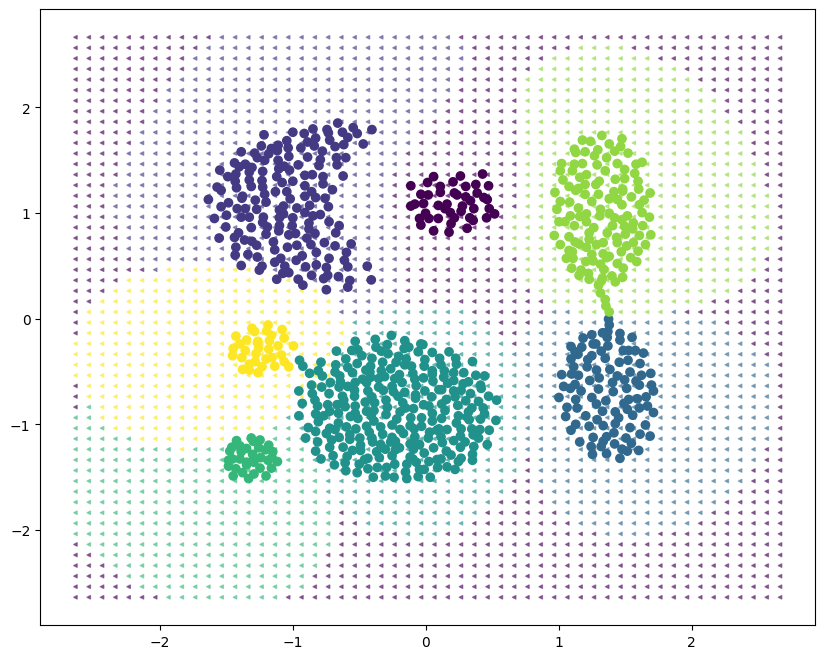

Applying SVM to Compound dataset
The accuracy of the SVM Classifier on the Compound dataset: 97.5
Decision Boundary for Compound dataset


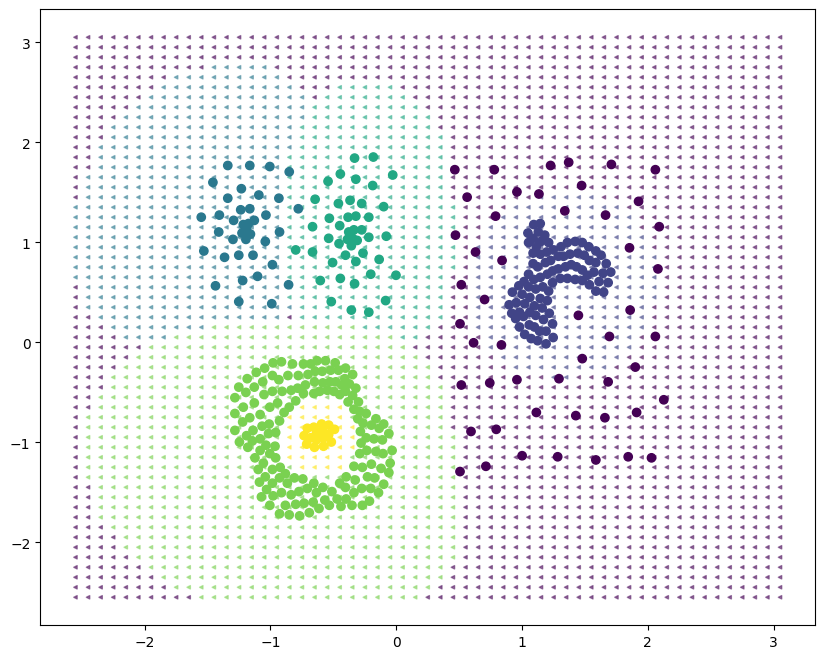

Applying SVM to Flame dataset
The accuracy of the SVM Classifier on the Flame dataset: 97.91666666666666
Decision Boundary for Flame dataset


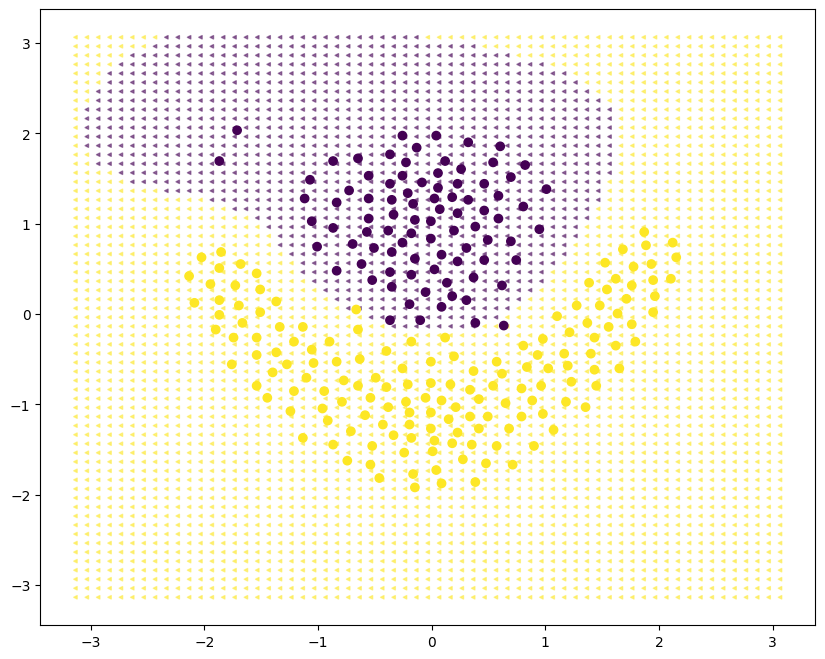

Applying SVM to Jain dataset
The accuracy of the SVM Classifier on the Jain dataset: 100.0
Decision Boundary for Jain dataset


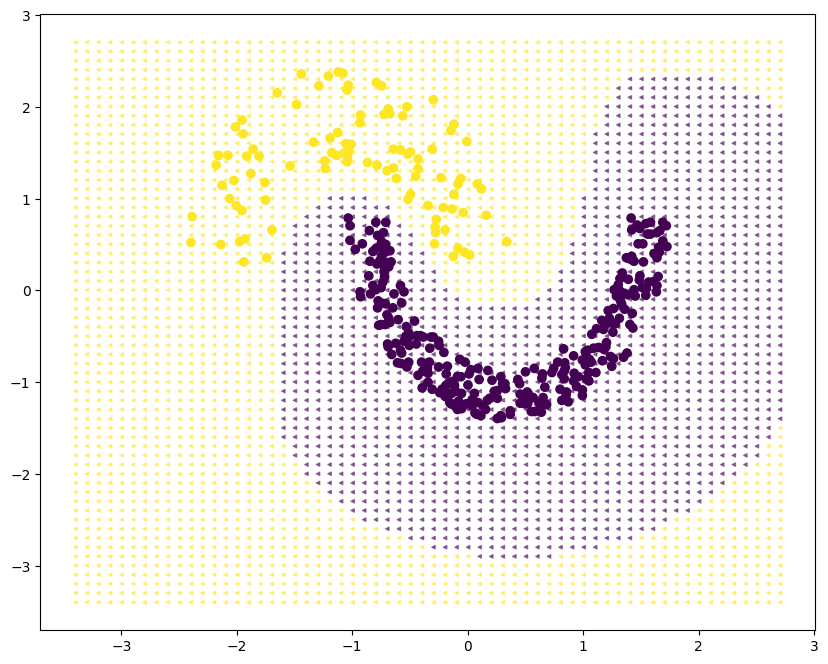

Applying SVM to Pathbased dataset
The accuracy of the SVM Classifier on the Pathbased dataset: 93.33333333333333
Decision Boundary for Pathbased dataset


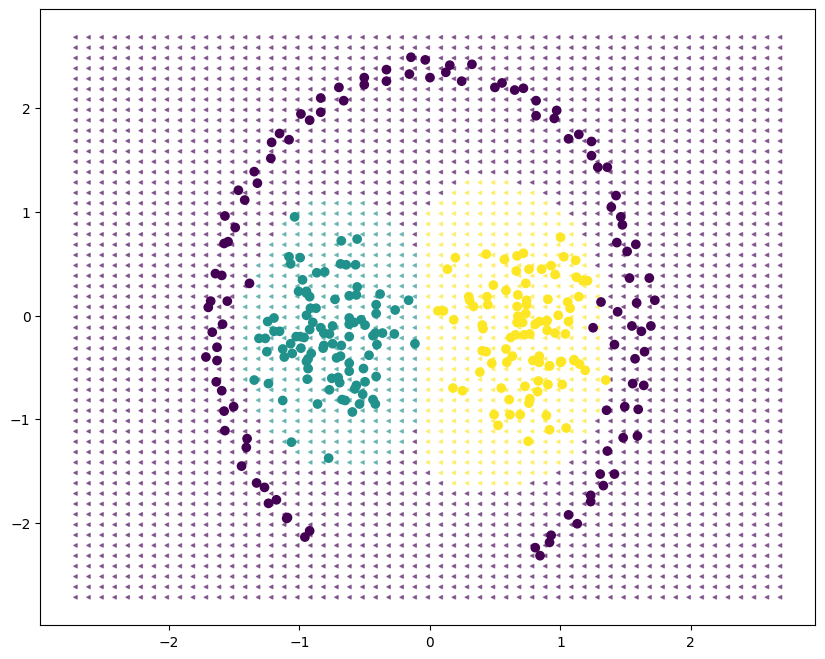

Applying SVM to Spiral dataset
The accuracy of the SVM Classifier on the Spiral dataset: 100.0
Decision Boundary for Spiral dataset


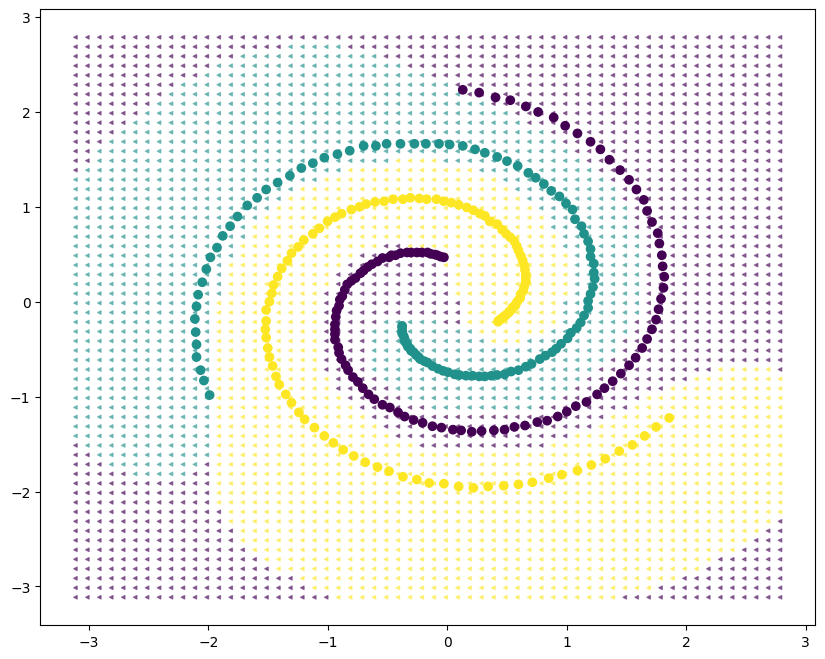

In [ ]:
applySVM('Aggregation')
applySVM('Compound')
applySVM('Flame')
applySVM('Jain')
applySVM('Pathbased')
applySVM('Spiral')